In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import re
import netCDF4 as nc

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)
import modules.utils as utils

import multiprocessing as mp

In [36]:
Directory = "/glade/scratch/sshamekh/LES_512_ug16wtspt01_data"
L = 32 

files = [name for name in os.listdir(Directory) if  name.__contains__("uxy")]
temp = [int(re.split('(\d+)', name)[3]) for name in files]
times = [t for n, t in enumerate(temp) if t not in temp[:n]]
times.sort()

t=30

variables = ['w', 'theta']  # add 's' to predict tracer flux
pool=mp.Pool(mp.cpu_count())
result_objects_raw = [pool.apply_async(utils.concatenate_alt, args=(Directory,variables[i],t,i,False)) for i in range(len(variables))]
raw_ds = [r.get()[1] for r in result_objects_raw]   # raw_ds[0] (resp 1,2,3) is the u (resp v,w,theta) dataset of shape(1,lz,512,512) with lz usually 376.
raw_ds[1][0] = 300*(raw_ds[1][0]-raw_ds[1][0].mean(axis=(1,2)).reshape(376,1,1))  # theta' : variations of theta instead of whole theta
pool.close()
pool.join() 

assert raw_ds[0].shape == raw_ds[1].shape ,'w and theta have different shape'

pool=mp.Pool(mp.cpu_count())
result_objects_coarse = [pool.apply_async(utils.coarse_array, args=(raw_ds[i], L,i,False)) for i in range(len(raw_ds))]
coarse_ds = [r.get()[1] for r in result_objects_coarse]
pool.close()
pool.join()

In [ ]:
wtheta_ds = raw_ds[0]*raw_ds[1]
#wtheta_ds=wtheta_ds*300
print('Mean heat flux :', np.abs(utils.coarse_array(wtheta_ds, L)).mean())
print('Max difference between objective and baseline :', (utils.coarse_array(wtheta_ds, L) - coarse_ds[0]*coarse_ds[1]).max())
output_ds = utils.variable_samples(utils.coarse_array(wtheta_ds, L))

In [45]:
wtheta_coarse32 = utils.coarse_array(wtheta_ds, L)

wtheta_mean32 = wtheta_coarse32[0].mean(axis=(1,2))
wtheta_std32 = wtheta_coarse32[0].std(axis=(1,2))
ecart32 = 1.96*wtheta_std32/16   # TCL

wtheta_coarse64 = utils.coarse_array(wtheta_ds, 2*L)

wtheta_mean64 = wtheta_coarse64[0].mean(axis=(1,2))
wtheta_std64 = wtheta_coarse64[0].std(axis=(1,2))
ecart64 = 1.96*wtheta_std32/8

print(wtheta_mean32[10], wtheta_mean64[10])

0.008651686707958177 0.008651686707958177


1.0725522994995296


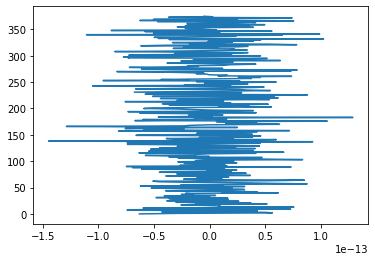

In [46]:
Z=np.arange(376)
#print(raw_ds[1][0][7].mean(),raw_ds[1][0][320].mean())
print(raw_ds[1].max())
plt.plot(np.mean(raw_ds[1][0],axis=(1,2)),Z)

In [47]:
print(1.96*(wtheta_ds[0][100].std())/512)
print(ecart32[100])

6.3972270888968e-05
0.0008622402790953186


Text(0.5, 1.0, 'Temperature variations vs altitude')

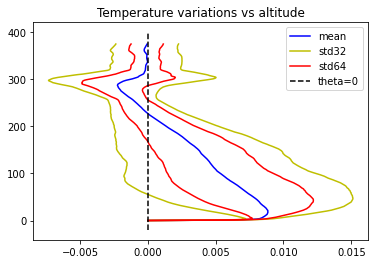

In [71]:
plt.plot(wtheta_mean32,Z,'b',label='mean')
#plt.plot(wtheta_mean64,Z)
plt.plot(wtheta_mean32+wtheta_std32,Z,'y',label='std32')
plt.plot(wtheta_mean32-wtheta_std32,Z,'y')
plt.plot(wtheta_mean64+wtheta_std64,Z,'r',label='std64')
plt.plot(wtheta_mean64-wtheta_std64,Z,'r')
plt.vlines(x=0, ymin=-20, ymax=400, colors='k', linestyles='dashed',label='theta=0')
plt.legend()
plt.title('Temperature variations vs altitude')
#plt.fill_between(Z, wtheta_mean-wtheta_std, wtheta_mean+wtheta_std, color='gray', alpha=0.2)